In [2]:
using CUDA, OrdinaryDiffEq, BenchmarkTools, LinearAlgebra, AbstractFFTs, FourierFlows

grid = TwoDGrid(GPU(); nx=512, Lx=2π, T=Float32)
mask = @. 9 <= grid.kr^2 + grid.l^2 < 36
A = 1000.0f0
ψh = A * (CUDA.rand(grid.nkr, grid.nl) + 1im * CUDA.rand(grid.nkr, grid.nl))
ψh[.~mask] .= 0.f0

ψ = irfft(ψh, grid.nx, (1, 2))

U = irfft(-1im * grid.l  .* ψh, grid.nx, (1, 2))
V = irfft( 1im * grid.kr .* ψh, grid.nx, (1, 2))

Ux = irfft( grid.l  .* grid.kr .* ψh, grid.nx, (1, 2))
Vx = irfft(-grid.kr .* grid.kr .* ψh, grid.nx, (1, 2))
Uy = irfft( grid.l  .* grid.l  .* ψh, grid.nx, (1, 2))

512×512 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.57164   1.57068   1.56576   1.55689   …  1.55093   1.56175   1.56866
 1.51772   1.51669   1.51183   1.50315      1.49797   1.50834   1.51493
 1.46223   1.46114   1.45636   1.44789      1.44345   1.45337   1.45964
 1.40528   1.40414   1.39944   1.39119      1.38746   1.39692   1.40287
 1.34696   1.34577   1.34116   1.33314      1.3301    1.3391    1.34473
 1.28735   1.28613   1.28162   1.27384   …  1.27144   1.27999   1.2853
 1.22657   1.22531   1.22092   1.21339      1.2116    1.21969   1.22469
 1.1647    1.16342   1.15915   1.15189      1.15067   1.1583    1.16299
 1.10185   1.10056   1.09642   1.08943      1.08875   1.09593   1.1003
 1.03813   1.03683   1.03283   1.02613      1.02594   1.03267   1.03674
 0.973637  0.972335  0.968485  0.96209   …  0.962355  0.968631  0.972398
 0.908486  0.907191  0.9035    0.897415     0.898092  0.903921  0.907392
 0.842784  0.841503  0.83798   0.832215     0.833262  0.838647  0.841828
 ⋮             

In [2]:
rms = sum(sqrt.(U.^2 + V.^2))/size(U, 1)/size(U, 2)

0.0926113f0

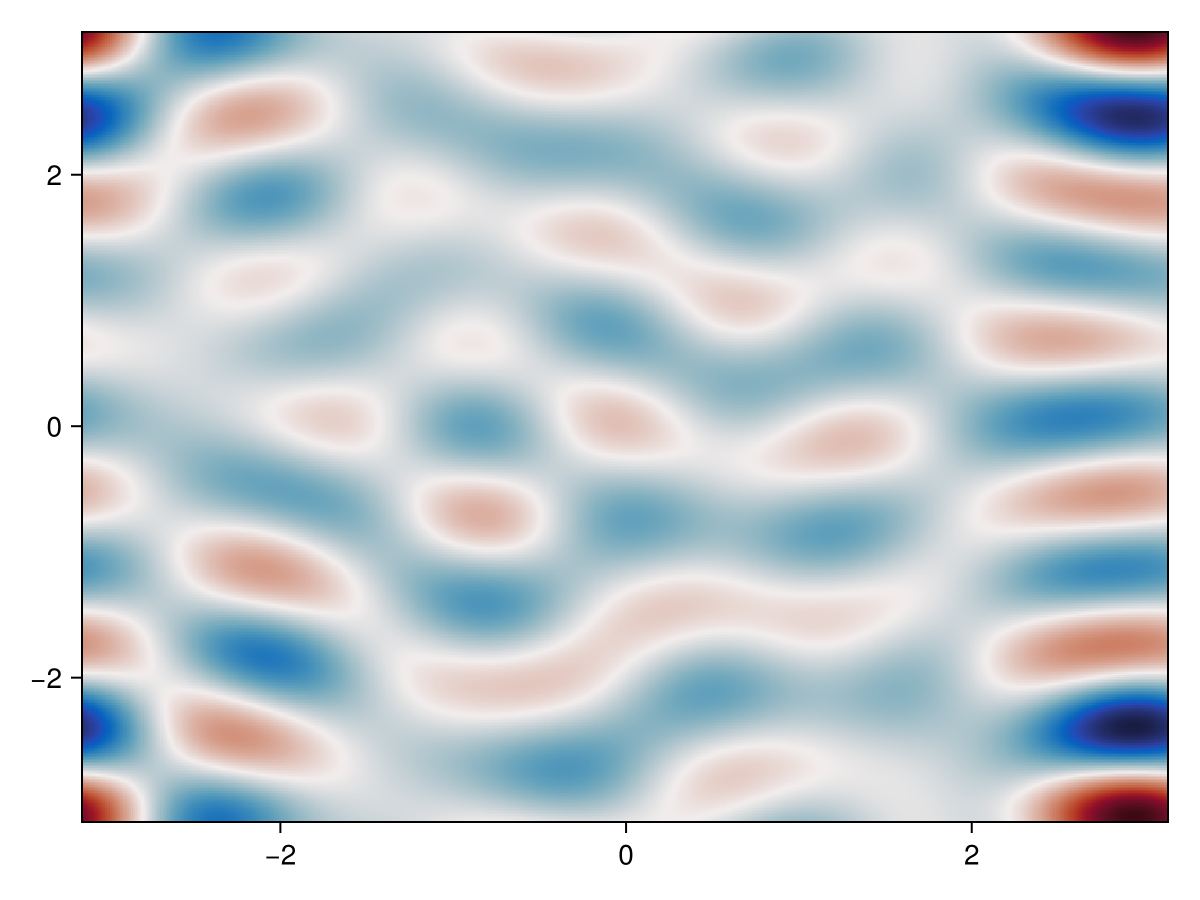

In [3]:
using CairoMakie

heatmap(grid.x, grid.y, Array(Uy); colormap=:balance)

In [14]:
function ω(k, p)
    return sqrt.(1 + k[1]*k[1] + k[2]*k[2])
end

function dxkdt(dxk, x, p, t)
    norm_x = @. (x - p.x0) / p.Lx + 0.5 / p.N
    nx = @views norm_x[1, :]
    ny = @views norm_x[2, :]
    
    k1 = @views x[3, :]
    k2 = @views x[4, :]

    ω = @. sqrt(1 + k1^2 + k2^2)
    Cg_x = @. k1 / ω
    Cg_y = @. k2 / ω

    dx1 = @views dxk[1, :]
    dx2 = @views dxk[2, :]
    dk1 = @views dxk[3, :]
    dk2 = @views dxk[4, :]
    
    broadcast!(dx1, nx, ny, Cg_x, Ref(p.U)) do xi, yi, cg, U
        U[xi, yi] + cg
    end
    broadcast!(dx2, nx, ny, Cg_y, Ref(p.V)) do xi, yi, cg, V
        V[xi, yi] + cg
    end
    
    broadcast!(dk1, nx, ny, k1, k2, Ref(p.Ux), Ref(p.Vx)) do xi, yi, k, l, Ux, Vx
        -(Ux[xi, yi] * k + Vx[xi, yi] * l)
    end
    broadcast!(dk2, nx, ny, k1, k2, Ref(p.Uy), Ref(p.Ux)) do xi, yi, k, l, Uy, negVy
        -(Uy[xi, yi] * k - negVy[xi, yi] * l)
    end
end

Np = 150
xk0 = CuArray{Float32}(undef, 4, Np)

@views xk0[1:2, :] .= cu(grid.Lx * rand(2, Np) .- grid.Lx/2)

phase = 2π*CUDA.rand(Float32, Np)

@views xk0[3, :] .= cos.(phase)
@views xk0[4, :] .= sin.(phase)

texU = CuTexture(U; interpolation=CUDA.LinearInterpolation(), address_mode=CUDA.ADDRESS_MODE_WRAP, normalized_coordinates=true)
texV = CuTexture(V; interpolation=CUDA.LinearInterpolation(), address_mode=CUDA.ADDRESS_MODE_WRAP, normalized_coordinates=true)
texUx = CuTexture(Ux; interpolation=CUDA.LinearInterpolation(), address_mode=CUDA.ADDRESS_MODE_WRAP, normalized_coordinates=true)
texUy = CuTexture(Uy; interpolation=CUDA.LinearInterpolation(), address_mode=CUDA.ADDRESS_MODE_WRAP, normalized_coordinates=true)
texVx = CuTexture(Vx; interpolation=CUDA.LinearInterpolation(), address_mode=CUDA.ADDRESS_MODE_WRAP, normalized_coordinates=true)

color = repeat(I(Np), 1, 4)
#color = zeros(Bool, 15, 4, 15)
params = (U = texU, V = texV, Ux = texUx, Uy = texUy, Vx = texVx, x0 = grid.x[1], Lx=grid.Lx, N = grid.nx)
params2 = (U = texU, V = texV, Ux = texUx, Uy = texUy, Vx = texVx, x0 = grid.x[1], Lx=grid.Lx, N = grid.nx)

#f = ODEFunction(dxkdt)#, jac_prototype=color)
prob = ODEProblem(dxkdt, xk0, (0.0f0, 1.0f0), params)
sol1 = solve(prob, Vern7(), save_start=true, save_on=false)
xk1 = first(sol1.u)

@btime ODEProblem(dxkdt, xk1, (1.0f0, 2.0f0), params2)
@btime remake(prob; u0 = xk1, p = params2, tspan = (1.0f0, 2.0f0))
#sol2 = solve(prob, Vern6(), save_start=true, save_on=false)
#sol1

  13.075 μs (71 allocations: 2.88 KiB)
  332.807 ns (13 allocations: 752 bytes)


ODEProblem with uType CuArray{Float32, 2, CUDA.DeviceMemory} and tType Float32. In-place: true
timespan: (1.0f0, 2.0f0)
u0: 4×150 CuArray{Float32, 2, CUDA.DeviceMemory}:
 -0.950495   0.496546  1.28042    …   0.163909   0.59904    -2.78534
  0.266689  -1.44066   2.00677       -0.740698  -1.75362    -0.294286
  0.798081   0.978171  0.997545       0.4353     0.0245712   0.787455
  0.60255   -0.207802  0.0700334      0.900285   0.999698    0.616372

In [58]:
idx1 = 1
idx2 = 2
sol = sol1
x1 = @views (sol.u[idx1][1, :] .- grid.x[1])/grid.Lx .+ 0.5/grid.nx
y1 = @views (sol.u[idx1][2, :] .- grid.x[1])/grid.Lx .+ 0.5/grid.nx
x2 = @views (sol.u[idx2][1, :] .- grid.x[1])/grid.Lx .+ 0.5/grid.nx
y2 = @views (sol.u[idx2][2, :] .- grid.x[1])/grid.Lx .+ 0.5/grid.nx
k1 = @views sol.u[idx1][3, :]
l1 = @views sol.u[idx1][4, :]
k2 = @views sol.u[idx2][3, :]
l2 = @views sol.u[idx2][4, :]

U1 = CuArray{Float32}(undef, Np)
V1 = CuArray{Float32}(undef, Np)
U2 = CuArray{Float32}(undef, Np)
V2 = CuArray{Float32}(undef, Np)

broadcast!(U1, x1, y1, Ref(texU)) do xi, yi, U
    U[xi, yi]
end
broadcast!(V1, x1, y1, Ref(texV)) do xi, yi, U
    U[xi, yi]
end
broadcast!(U2, x2, y2, Ref(texU)) do xi, yi, U
    U[xi, yi]
end
broadcast!(V2, x2, y2, Ref(texV)) do xi, yi, U
    U[xi, yi]
end

ω1 = @. sqrt(1 + k1^2 + l1^2)
ω2 = @. sqrt(1 + k2^2 + l2^2)
Ω1 = @. ω1 + U1*k1 + V1*l1
Ω2 = @. ω2 + U2*k2 + V2*l2
percent_diff = sum(@. abs(Ω2 - Ω1) / Ω1)/Np * 100

0.041274782f0

In [7]:
A = [1, 2, 3, 4]

4-element Vector{Int64}:
 1
 2
 3
 4

In [9]:
@btime A[1]
@btime first(A)t

  15.723 ns (0 allocations: 0 bytes)
  13.913 ns (0 allocations: 0 bytes)


1

1.0009765625:0.03125:1.9697265625


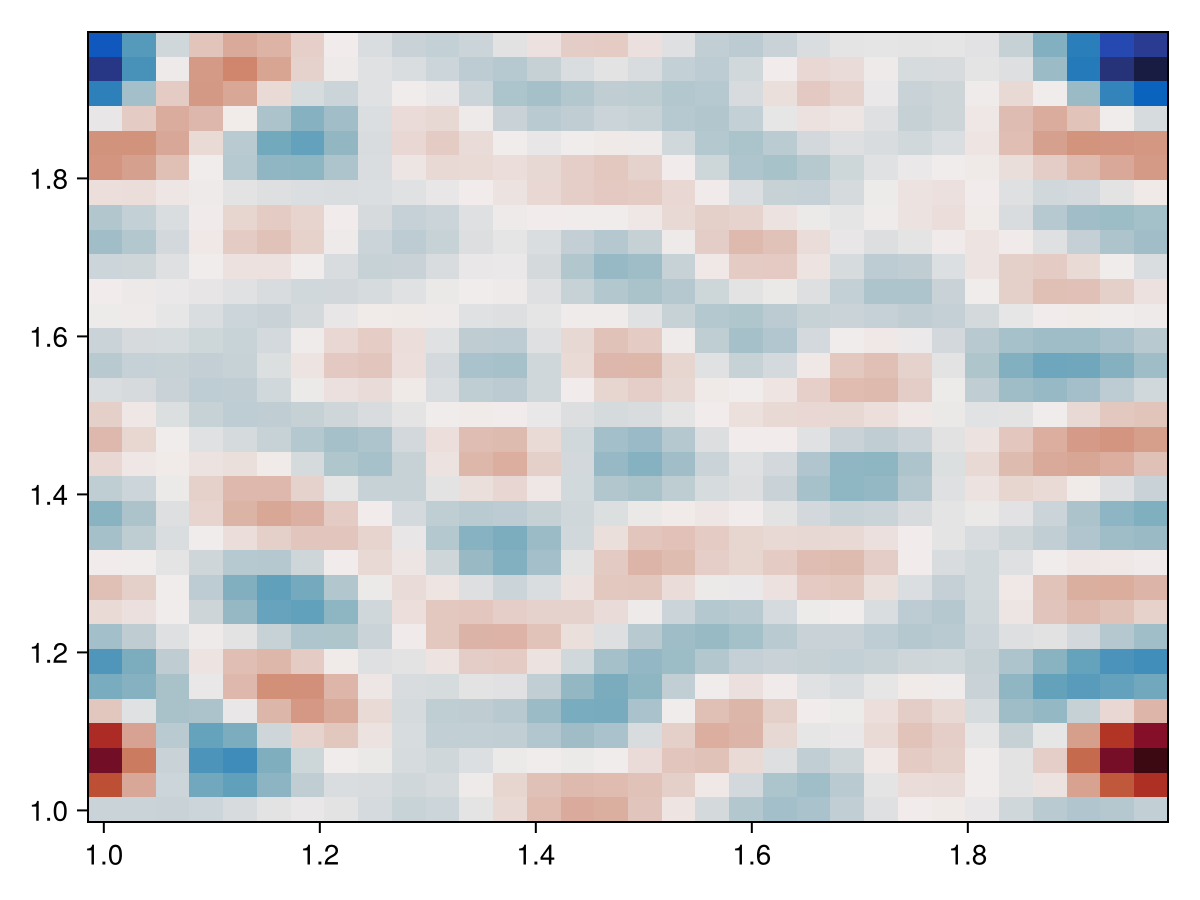

In [150]:
test_length = 32
x = ((0.0f0:(test_length - 1))) / test_length .+ 0.5/grid.nx .+ 1
y = ((0.0f0:(test_length - 1))) / test_length .+ 0.5/grid.nx .+ 1
println(x)
Utest = CuArray{Float32}(undef, test_length, test_length)
broadcast!(Utest, x, y', Ref(texU)) do x, y, U
    U[x, y]
end
heatmap(x, y, Array(Utest), colormap=:balance)

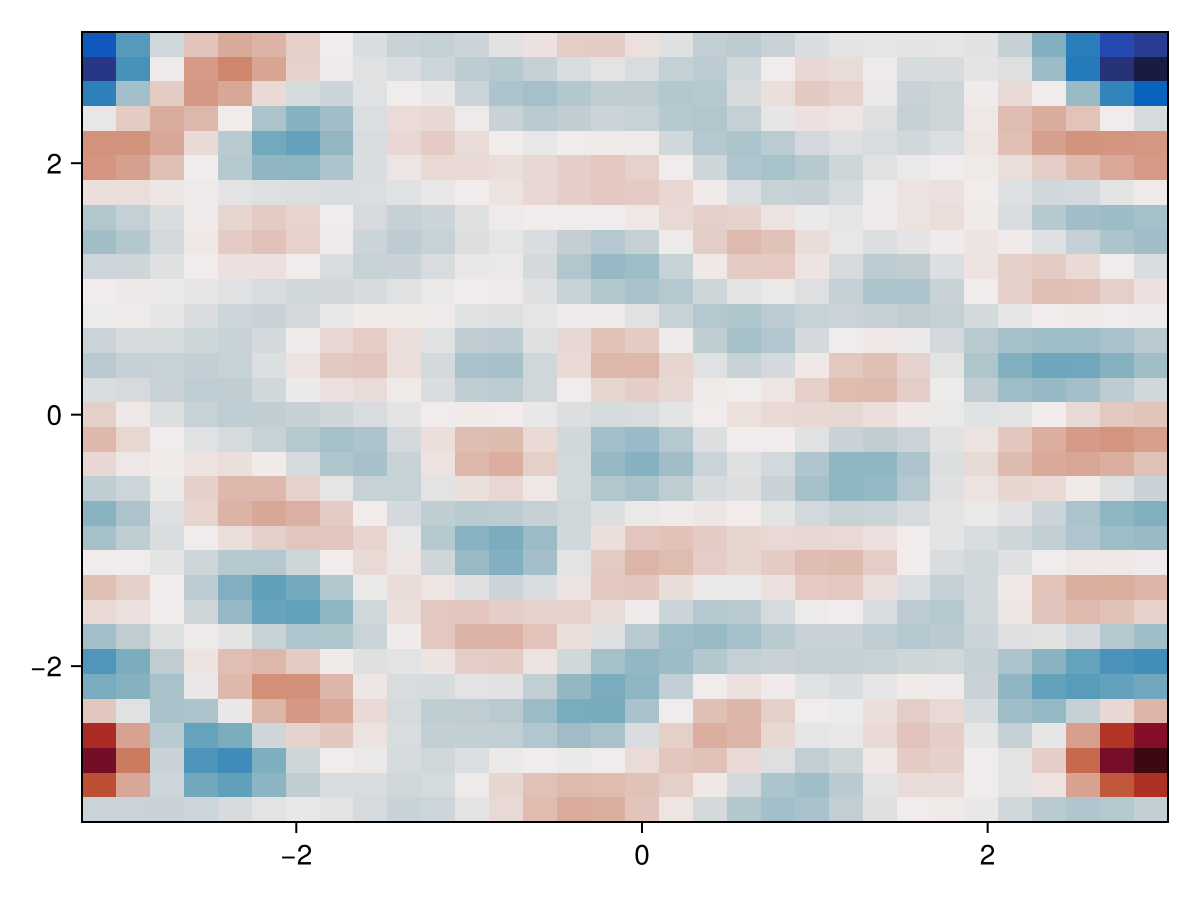

In [125]:
stride = 16
pickU = Array(U)[1:stride:end,1:stride:end]
heatmap(grid.x[1:stride:end], grid.y[1:stride:end], pickU, colormap=:balance)

In [151]:
Array(Utest)

32×32 Matrix{Float32}:
 -0.0347635     0.269193     0.414016     …  -0.377784    -0.305529
 -0.0336821     0.130651     0.20288         -0.193774    -0.174731
 -0.0359857    -0.0318174   -0.036054         0.0131202   -0.0262509
 -0.0319721    -0.141161    -0.188969         0.152549     0.0839766
 -0.0179015    -0.160675    -0.206674         0.184774     0.127591
 -0.000544745  -0.111273    -0.12605      …   0.135068     0.112416
  0.00765872   -0.0472458   -0.0299253        0.0626252    0.0677662
 -0.000842238  -0.0129573    0.0176399        0.0133842    0.0214632
 -0.0209947    -0.0148369    0.00929458      -0.00550177  -0.0133308
 -0.0367836    -0.0269996   -0.0181166       -0.0146047   -0.0350794
 -0.0314826    -0.0201604   -0.0267459    …  -0.0317101   -0.0432123
  0.000839458   0.0132195   -0.010133        -0.0525556   -0.0332892
  0.0506978     0.0570124    0.0106205       -0.0587251   -0.00300639
  ⋮                                       ⋱   ⋮           
 -0.0827784    -0.071864

In [152]:
pickU

32×32 Matrix{Float32}:
 -0.0347635     0.269193     0.414016     …  -0.377784    -0.305529
 -0.0336821     0.130651     0.20288         -0.193774    -0.174731
 -0.0359857    -0.0318174   -0.036054         0.0131202   -0.0262509
 -0.0319721    -0.141161    -0.188969         0.152549     0.0839766
 -0.0179015    -0.160675    -0.206674         0.184774     0.127591
 -0.000544745  -0.111273    -0.12605      …   0.135068     0.112416
  0.00765872   -0.0472458   -0.0299253        0.0626252    0.0677662
 -0.000842238  -0.0129573    0.0176399        0.0133842    0.0214632
 -0.0209947    -0.0148369    0.00929458      -0.00550177  -0.0133308
 -0.0367836    -0.0269996   -0.0181166       -0.0146047   -0.0350794
 -0.0314826    -0.0201604   -0.0267459    …  -0.0317101   -0.0432123
  0.000839458   0.0132195   -0.010133        -0.0525556   -0.0332892
  0.0506978     0.0570124    0.0106205       -0.0587251   -0.00300639
  ⋮                                       ⋱   ⋮           
 -0.0827784    -0.071864

In [97]:
N = 3
M = 512

Np_ = 1024
src = rand(Float32, fill(M, N)...)
println(size(src))
# indices we want to interpolate
idx = [tuple(rand(1:0.1:10, N)...) for _ in 1:Np_]

# upload to the GPU
gpu_src = CuArray(src)
gpu_idx = CuArray(idx)

# create a texture array for optimized fetching
# this is required for N=1, optional for N=2 and N=3
gpu_src = CuTextureArray(gpu_src)

# interpolate using a texture
gpu_dst = CuArray{Float32}(undef, size(gpu_idx))
gpu_tex = CuTexture(gpu_src; interpolation=CUDA.NearestNeighbour())
broadcast!(gpu_dst, gpu_idx, Ref(gpu_tex)) do idx, tex
    tex[idx...]
end

(512, 512, 512)


1024-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.99811745
 0.18802541
 0.8384292
 0.05586016
 0.77288616
 0.32894212
 0.46386796
 0.8665595
 0.43167388
 0.27394354
 0.03872335
 0.9324983
 0.45263016
 ⋮
 0.75673676
 0.84091747
 0.8915273
 0.88421345
 0.40188366
 0.81597435
 0.3032747
 0.70633674
 0.3958009
 0.445781
 0.15211958
 0.29575068

In [110]:
using CUDA, OrdinaryDiffEq, BenchmarkTools, LinearAlgebra

function f2!(du, u, p, t)
    idx = convert.(Int, floor.(u * length(p.U)) .+ 1)
    idx  = mod.(idx, length(p.U)) .+ 1
    idx2 = mod.(idx .+ 1, length(p.U)) .+ 1
    alpha = length(u.P) * u - idx .+ 1
    du .= alpha .* p.U[idx] + (1 .- alpha) .* p.U[idx2]
end

u0 = rand(100000)
U = randn(1000)
f(du, u, p, t) = mul!(du, A, u)
prob = ODEProblem{true}(f2!, u0, (0.0f0, 1.0f0), (U = u0, )) # Float32 is better on GPUs!
@btime sol = solve(prob, Tsit5(), save_on = false, save_start=false)

LoadError: InterruptException:

In [104]:
x = randn(100, 2)
out = Array{Float64}(undef, 100)
broadcast(x) do x
    [x[1] + x]
end

100×2 Matrix{Vector{Float64}}:
 [-3.9133]    [0.563847]
 [-4.52494]   [1.42397]
 [-1.94109]   [2.5186]
 [0.730656]   [-0.820236]
 [0.123608]   [2.64313]
 [-1.12351]   [-1.28807]
 [2.97067]    [4.43627]
 [-0.541928]  [2.13978]
 [0.234611]   [1.61773]
 [-3.45133]   [1.68134]
 [0.0773757]  [3.51538]
 [1.14896]    [1.45314]
 [-4.04564]   [-1.0486]
 ⋮            
 [-5.33205]   [-0.48974]
 [0.347253]   [0.577065]
 [1.00637]    [3.26326]
 [0.642816]   [-1.73338]
 [-0.924008]  [-3.27307]
 [-3.13019]   [2.02849]
 [-1.24601]   [-1.25738]
 [2.60539]    [-1.67728]
 [2.33507]    [-0.962554]
 [-0.530396]  [-1.15806]
 [-0.249822]  [2.01532]
 [-3.83486]   [-1.87549]